In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Task 1

In [2]:
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")
df = pd.read_csv(f"{path}/train.csv")
df = df.sample(n=2000, random_state=0)

## Missing Values

In [3]:
df.drop(columns=["Unnamed: 0", "id", "Gender"], inplace=True)
df.dropna(inplace=True)

## Encoding

In [4]:
le = LabelEncoder()
df["Customer Type"] = le.fit_transform(df["Customer Type"])
df["Type of Travel"] = le.fit_transform(df["Type of Travel"])
df["satisfaction"] = le.fit_transform(df["satisfaction"])

In [5]:
ohe = OneHotEncoder(sparse_output=False)
class_encoded = ohe.fit_transform(df[["Class"]])
feature_names = ohe.get_feature_names_out(["Class"])
class_df = pd.DataFrame(class_encoded, columns=feature_names, index=df.index)
new_feature_names = ["Business", "Eco", "Eco Plus"]
class_df.columns = new_feature_names
df = pd.concat([df.drop('Class', axis=1), class_df], axis=1)

## Feature Scaling

In [6]:
scaler = StandardScaler()
cols_to_scale = df.columns.drop("satisfaction")

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

## Review

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 70655 to 7903
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer Type                      1994 non-null   float64
 1   Age                                1994 non-null   float64
 2   Type of Travel                     1994 non-null   float64
 3   Flight Distance                    1994 non-null   float64
 4   Inflight wifi service              1994 non-null   float64
 5   Departure/Arrival time convenient  1994 non-null   float64
 6   Ease of Online booking             1994 non-null   float64
 7   Gate location                      1994 non-null   float64
 8   Food and drink                     1994 non-null   float64
 9   Online boarding                    1994 non-null   float64
 10  Seat comfort                       1994 non-null   float64
 11  Inflight entertainment             1994 non-null   float6

In [8]:
df.head()

,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Business,Eco,Eco Plus
70655,-0.461406,-0.029579,-0.696230,2.381953,0.228910,-0.014638,0.900660,0.016655,1.368567,0.567284,...,0.319623,0.545372,0.279435,-0.188275,-0.377490,-0.385728,1,1.028490,-0.883378,-0.286237
56114,-0.461406,1.836455,1.436308,0.870725,-0.531835,0.648744,-0.518476,0.016655,1.368567,0.567284,...,-1.391326,1.335686,-1.459077,1.310408,-0.377490,-0.385728,0,-0.972299,1.132018,-0.286237
95351,-0.461406,-1.095884,1.436308,-0.327563,-0.531835,-0.014638,-0.518476,0.016655,-1.612233,-0.897006,...,0.319623,-1.035256,0.279435,-1.686958,0.369004,0.397138,0,-0.972299,1.132018,-0.286237
32181,-0.461406,1.369947,-0.696230,-0.776178,-1.292580,1.312127,1.610228,1.598113,-1.612233,-0.164861,...,-2.246800,-1.825570,-2.328333,-1.686958,-0.228191,-0.385728,0,1.028490,-0.883378,-0.286237
5214,-0.461406,-0.696020,-0.696230,-0.961368,1.750400,1.312127,1.610228,1.598113,1.368567,1.299429,...,1.175097,-0.244942,-1.459077,1.310408,-0.377490,-0.385728,1,-0.972299,-0.883378,3.493608


In [9]:
df.shape

(1994, 24)

## Before PCA

### Training and Testing Data

In [10]:
X = df.drop("satisfaction", axis=1)
y = df["satisfaction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### k-NN

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)

start_fit = time.time()
knn.fit(X_train, y_train)
end_fit = time.time()
fit_time_knn = end_fit - start_fit
print(f"Training time: {fit_time_knn:.4f}")

start_pred = time.time()
y_pred = knn.predict(X_test)
end_pred = time.time()
predict_time_knn = end_pred - start_pred
print(f"Prediction time: {predict_time_knn:.4f}")

result_knn = round(knn.score(X_test, y_test), 2)
print(f"Accuracy: {result_knn}")

Training time: 0.0064
Prediction time: 0.0608
Accuracy: 0.9


### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

start_fit = time.time()
rf.fit(X_train, y_train)
end_fit = time.time()
fit_time_rf = end_fit - start_fit
print(f"Training time: {fit_time_rf:.4f}")

start_pred = time.time()
y_pred = rf.predict(X_test)
end_pred = time.time()
predict_time_rf = end_pred - start_pred
print(f"Prediction time: {predict_time_rf:.4f}")

result_rf = round(rf.score(X_test, y_test), 2)
print(f"Accuracy: {result_rf}")

Training time: 0.2514
Prediction time: 0.0119
Accuracy: 0.92


## PCA

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [14]:
print(X_pca.shape)

(1994, 2)


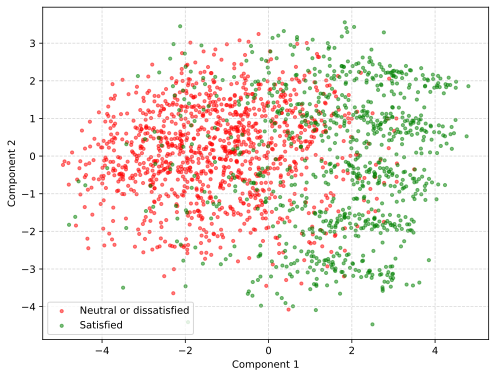

In [15]:
plt.figure(figsize=(8, 6))

plt.scatter(
    X_pca[y == 0, 0],
    X_pca[y == 0, 1],
    s=10,
    alpha=0.5,
    c="red",
    label="Neutral or dissatisfied"
)

plt.scatter(
    X_pca[y == 1, 0],
    X_pca[y == 1, 1],
    s=10,
    alpha=0.5,
    c="green",
    label="Satisfied"
)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## After PCA

### Training and Testing Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=0)

### k-NN

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)

start_fit = time.time()
knn.fit(X_train, y_train)
end_fit = time.time()
fit_time_knn_pca = end_fit - start_fit
print(f"Training time: {fit_time_knn_pca:.4f}")

start_pred = time.time()
y_pred = knn.predict(X_test)
end_pred = time.time()
predict_time_knn_pca = end_pred - start_pred
print(f"Prediction time: {predict_time_knn_pca:.4f}")

result_knn_pca = round(knn.score(X_test, y_test), 2)
print(f"Accuracy: {result_knn_pca}")

Training time: 0.0046
Prediction time: 0.0032
Accuracy: 0.81


### Random Forest

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

start_fit = time.time()
rf.fit(X_train, y_train)
end_fit = time.time()
fit_time_rf_pca = end_fit - start_fit
print(f"Training time: {fit_time_rf_pca:.4f}")

start_pred = time.time()
y_pred = rf.predict(X_test)
end_pred = time.time()
predict_time_rf_pca = end_pred - start_pred
print(f"Prediction time: {predict_time_rf_pca:.4f}")

result_rf_pca = round(rf.score(X_test, y_test), 2)
print(f"Accuracy: {result_rf_pca}")

Training time: 0.2921
Prediction time: 0.0109
Accuracy: 0.82


## Visualization of results

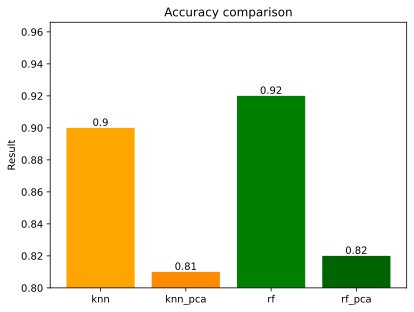

In [19]:
labels = ["knn", "knn_pca", "rf", "rf_pca"]
values = [result_knn, result_knn_pca, result_rf, result_rf_pca]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=["orange", "darkorange", "green", "darkgreen"])
ax.bar_label(bars)
ax.set_ylim(0.8)
ax.set_ylabel("Result")
ax.set_title("Accuracy comparison")
plt.show()

## t-SNE

In [20]:
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X_pca)

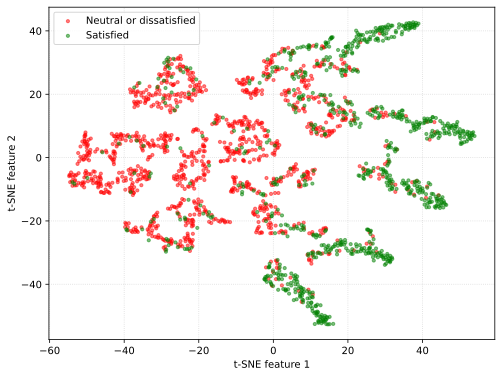

In [21]:
plt.figure(figsize=(8, 6))

plt.scatter(
    X_tsne[y == 0, 0],
    X_tsne[y == 0, 1],
    s=10,
    alpha=0.5,
    c="red",
    label="Neutral or dissatisfied"
)

plt.scatter(
    X_tsne[y == 1, 0],
    X_tsne[y == 1, 1],
    s=10,
    alpha=0.5,
    c="green",
    label="Satisfied"
)

plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# Task 2

Shape: (427, 640, 3)
dtype: uint8


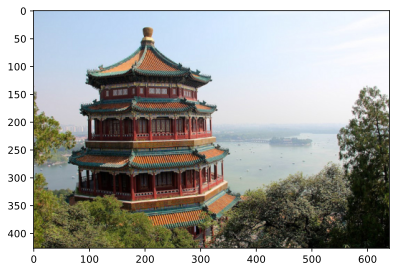

In [22]:
image = load_sample_image("china.jpg")
h, w, c = image.shape

print("Shape:", image.shape)
print("dtype:", image.dtype)

plt.imshow(image)
plt.show()

In [23]:
data = image / 255.0
pixels = data.reshape(-1, 3)

unique_colors = np.unique(image.reshape(-1, 3), axis=0)
print("Unique colors in the original image:", unique_colors.shape[0])

Unique colors in the original image: 96615


Unique colors in the converted image: 64


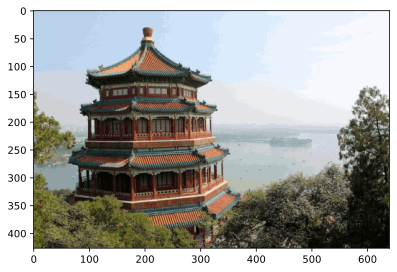

Unique colors in the converted image: 32


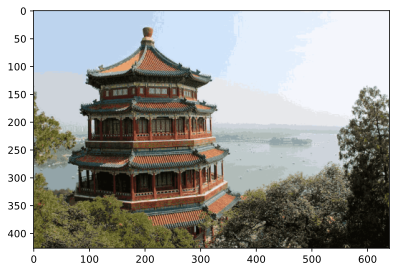

Unique colors in the converted image: 16


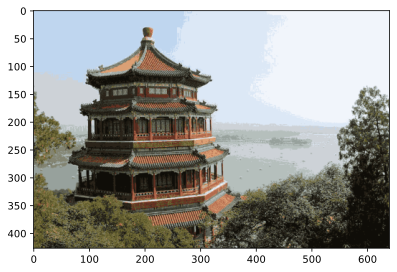

Unique colors in the converted image: 8


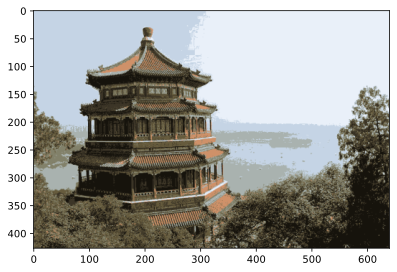

In [24]:
k_values = [64, 32, 16, 8]

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(pixels)
    
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_image = new_colors.reshape(image.shape)
    
    unique_colors = np.unique(quantized_image.reshape(-1, 3), axis=0)
    print("Unique colors in the converted image:", unique_colors.shape[0])
    
    plt.imshow(quantized_image)
    plt.show()

# Task 3

In [25]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nik4nd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
df = pd.read_csv(f"{path}/bbc-news-data.csv", sep="\t")

## Review

In [27]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Categories:", df["category"].unique())

Shape: (2225, 4)
Columns: ['category', 'filename', 'title', 'content']
Categories: ['business' 'entertainment' 'politics' 'sport' 'tech']


In [28]:
categories = ["business", "tech"]
df = df[df["category"].isin(categories)]

print("Categories:", df["category"].unique())

Categories: ['business' 'tech']


## Preprocessing

In [29]:
stop_words = stopwords.words("english")


def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words]
    
    return " ".join(filtered_words)


df["clean_content"] = df["content"].apply(preprocess_text)

## Visualization

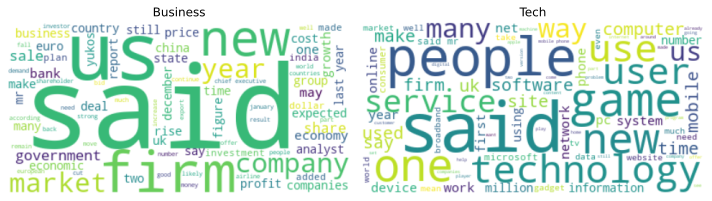

In [30]:
categories = df["category"].unique()

plt.figure(figsize=(10, 8))

for i, category in enumerate(categories):
    subset = df[df["category"] == category]
    text_data = " ".join(subset["clean_content"])

    wc = WordCloud(
        max_words=80,
        collocations=True,
        background_color="white"
    ).generate(text_data)

    plt.subplot(1, 2, i+1)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(category.capitalize())

plt.tight_layout()
plt.show()

## tf–idf

In [31]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")
X = tfidf.fit_transform(df["clean_content"])
y = df["category"]

## Training and Testing Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Logistic Regression

In [33]:
logr = LogisticRegression(max_iter=1000, random_state=0)
logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)

## Results

In [34]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

Accuracy: 98.25%


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.98      0.98      0.98       126
        tech       0.98      0.98      0.98       102

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228



In [36]:
confusion_matrix(y_test, y_pred)

array([[124,   2],
       [  2, 100]])